<a href="https://colab.research.google.com/github/frimpongsarfok/AI_Breast_Cancer_Classification_VSU/blob/main/BUSI_Explainable_CNN_GradCAM_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable CNN (ResNet-18) + Grad-CAM for Breast Ultrasound (BUSI)
**Google Colab Experimental Notebook (Dataset: BUSI from Kaggle)**

This notebook is experiment-first:
- Load BUSI (Kaggle) data
- builds train/val/test splits  
- trains a **baseline CNN (ResNet-18)**  
- evaluates metrics + confusion matrix  
- produces **Grad-CAM visual explanations** (and optional comparison to BUSI ground-truth masks)

> Label setup (binary): **malignant = 1**, **benign + normal = 0**.


## 0) Setup: GPU




In [17]:
# --- Environment check ---
import torch
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


PyTorch: 2.9.0+cpu
CUDA available: False


## 1) Build a DataFrame (images + class + mask path)

BUSI commonly contains folders like:
- `Dataset_BUSI_with_GT/benign`
- `Dataset_BUSI_with_GT/malignant`
- `Dataset_BUSI_with_GT/normal`

Each lesion image often has a corresponding `*_mask.png`.  
We **exclude masks from training** but keep their paths for visual comparison.


In [18]:
import os
import pandas as pd

DATA_ROOT = "/content/Dataset_BUSI_with_GT"

# locate dataset root that contains the 3 class folders
candidate = os.path.join(DATA_ROOT, "Dataset_BUSI_with_GT")
if os.path.isdir(candidate):
    BUSI_ROOT = candidate
else:
    # fallback search
    BUSI_ROOT = DATA_ROOT

classes = ["benign", "malignant", "normal"]
rows = []

for cls in classes:
    cls_dir = os.path.join(BUSI_ROOT, cls)
    if not os.path.isdir(cls_dir):
        print("Missing class dir:", cls_dir)
        continue
    for fn in os.listdir(cls_dir):
        if not fn.lower().endswith(".png"):
            continue
        if "_mask" in fn.lower():
            continue  # skip mask files as inputs
        img_path = os.path.join(cls_dir, fn)

        base = fn[:-4]
        mask_path = os.path.join(cls_dir, base + "_mask.png")
        if not os.path.exists(mask_path):
            mask_path = None

        rows.append({"image_path": img_path, "class": cls, "mask_path": mask_path})

df = pd.DataFrame(rows)
print("Total images (excluding masks):", len(df))
df.head()


Total images (excluding masks): 780


,image_path,class,mask_path
0,/content/Dataset_BUSI_with_GT/benign/benign (9...,benign,/content/Dataset_BUSI_with_GT/benign/benign (9...
1,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign,/content/Dataset_BUSI_with_GT/benign/benign (3...
2,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign,/content/Dataset_BUSI_with_GT/benign/benign (3...
3,/content/Dataset_BUSI_with_GT/benign/benign (7...,benign,/content/Dataset_BUSI_with_GT/benign/benign (7...
4,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign,/content/Dataset_BUSI_with_GT/benign/benign (3...


In [19]:
# Binary label (recommended): malignant=1, benign/normal=0
df["label"] = (df["class"] == "malignant").astype(int)

print("Class counts (3-class):")
print(df["class"].value_counts())
print("\nLabel counts (binary):")
print(df["label"].value_counts())

df.sample(5, random_state=42)


Class counts (3-class):
class
benign       437
malignant    210
normal       133
Name: count, dtype: int64

Label counts (binary):
label
0    570
1    210
Name: count, dtype: int64


,image_path,class,mask_path,label
595,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant,/content/Dataset_BUSI_with_GT/malignant/malign...,1
587,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant,/content/Dataset_BUSI_with_GT/malignant/malign...,1
543,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant,/content/Dataset_BUSI_with_GT/malignant/malign...,1
644,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant,/content/Dataset_BUSI_with_GT/malignant/malign...,1
487,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant,/content/Dataset_BUSI_with_GT/malignant/malign...,1


## 2) Train / Validation / Test Split (Stratified)

We split using stratification on the **binary label** to preserve class balance.


In [20]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=42, stratify=df["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df["label"]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train label counts:\n", train_df["label"].value_counts())
print("Val label counts:\n", val_df["label"].value_counts())
print("Test label counts:\n", test_df["label"].value_counts())


Train: 546 Val: 117 Test: 117
Train label counts:
 label
0    399
1    147
Name: count, dtype: int64
Val label counts:
 label
0    85
1    32
Name: count, dtype: int64
Test label counts:
 label
0    86
1    31
Name: count, dtype: int64


## 3) PyTorch Dataset + DataLoaders

In [21]:
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class BUSIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("L")   # ultrasound grayscale
        img = img.convert("RGB")                           # for ResNet

        label = int(row["label"])
        mask_path = row["mask_path"]

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long), row["image_path"], mask_path

IMG_SIZE = 224
BATCH_SIZE = 16

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_loader = DataLoader(BUSIDataset(train_df, train_transform), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(BUSIDataset(val_df, val_test_transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(BUSIDataset(test_df, val_test_transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

len(train_df), len(val_df), len(test_df)


(546, 117, 117)

## 4) Baseline CNN Model (ResNet-18 Fine-tuning)

In [22]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_model(pretrained=True, num_classes=2):
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = create_model(pretrained=True, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

model


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 99.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 5) Training Loop + Curves

In [23]:
from tqdm import tqdm
import copy

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels, _, _ in tqdm(loader, desc="Train", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels, _, _ in tqdm(loader, desc="Val", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

EPOCHS = 12
best_val_loss = float("inf")
best_model_wts = copy.deepcopy(model.state_dict())

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    va_loss, va_acc = eval_one_epoch(model, val_loader, criterion, device)
    scheduler.step(va_loss)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
    print(f"Val   Loss: {va_loss:.4f} | Val   Acc: {va_acc:.4f}")

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "best_resnet18_busi.pth")
        print("  -> Best model saved")

# load best model
model.load_state_dict(torch.load("best_resnet18_busi.pth", map_location=device))
model.to(device)



Epoch 1/12


Train Loss: 0.4409 | Train Acc: 0.8022
Val   Loss: 0.4084 | Val   Acc: 0.8205
  -> Best model saved

Epoch 2/12


Train Loss: 0.2621 | Train Acc: 0.8974
Val   Loss: 0.3472 | Val   Acc: 0.8632
  -> Best model saved

Epoch 3/12


Train Loss: 0.1772 | Train Acc: 0.9304
Val   Loss: 0.2991 | Val   Acc: 0.8547
  -> Best model saved

Epoch 4/12


Train Loss: 0.1362 | Train Acc: 0.9432
Val   Loss: 0.2832 | Val   Acc: 0.8376
  -> Best model saved

Epoch 5/12


Train Loss: 0.1460 | Train Acc: 0.9487
Val   Loss: 0.3310 | Val   Acc: 0.8718

Epoch 6/12


Train Loss: 0.1139 | Train Acc: 0.9524
Val   Loss: 0.3264 | Val   Acc: 0.8889

Epoch 7/12


Train Loss: 0.0954 | Train Acc: 0.9652
Val   Loss: 0.3010 | Val   Acc: 0.8547

Epoch 8/12


Train Loss: 0.0870 | Train Acc: 0.9689
Val   Loss: 0.2004 | Val   Acc: 0.9145
  -> Best model saved

Epoch 9/12


Train Loss: 0.1114 | Train Acc: 0.9615
Val   Loss: 0.2048 | Val   Acc: 0.9231

Epoch 10/12


Train Loss: 0.0754 | Train Acc: 0.9725
Val   Loss: 0.4101 | Val   Acc: 0.8632

Epoch 11/12


Train Loss: 0.0493 | Train Acc: 0.9817
Val   Loss: 0.2228 | Val   Acc: 0.9231

Epoch 12/12


Train Loss: 0.0541 | Train Acc: 0.9817
Val   Loss: 0.4219 | Val   Acc: 0.8376


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

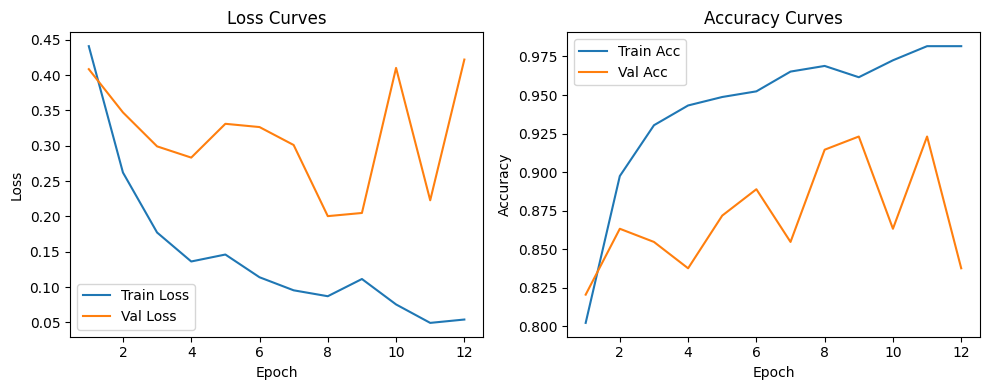

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves"); plt.legend()

plt.tight_layout()
plt.show()


## 6) Test Evaluation (Metrics + Confusion Matrix)

Accuracy: 0.9487179487179487
Precision: 0.9310344827586207
Recall (Sensitivity): 0.8709677419354839
F1: 0.9
ROC-AUC: 0.9816204051012754

Classification Report:
               precision    recall  f1-score   support

           0     0.9545    0.9767    0.9655        86
           1     0.9310    0.8710    0.9000        31

    accuracy                         0.9487       117
   macro avg     0.9428    0.9239    0.9328       117
weighted avg     0.9483    0.9487    0.9482       117

Confusion Matrix:
 [[84  2]
 [ 4 27]]


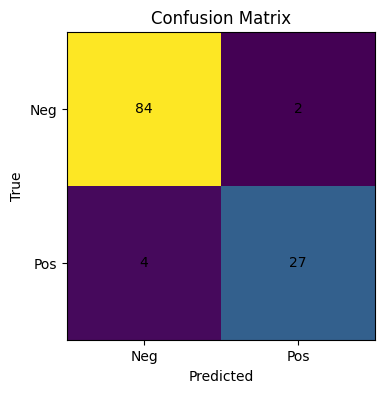

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import torch

def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for images, labels, _, _ in tqdm(loader, desc="Test", leave=False):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = outputs.argmax(dim=1).cpu().numpy()

            y_true.extend(labels.numpy().tolist())
            y_pred.extend(preds.tolist())
            y_prob.extend(probs.tolist())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

y_true, y_pred, y_prob = evaluate(model, test_loader, device)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, zero_division=0))
print("Recall (Sensitivity):", recall_score(y_true, y_pred, zero_division=0))
print("F1:", f1_score(y_true, y_pred, zero_division=0))
try:
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))
except Exception as e:
    print("ROC-AUC error:", e)

print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1], ["Neg","Pos"]); plt.yticks([0,1], ["Neg","Pos"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.show()


## 7) Grad-CAM (Visual Results) + Optional GT Mask Overlay

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch


class GradCAM:
    def __init__(self, model, target_layer_name="layer4"):
        self.model = model
        self.model.eval()
        self.target_layer = dict([*self.model.named_modules()])[target_layer_name]
        self.activations = None
        self.gradients = None

        self.fwd_handle = self.target_layer.register_forward_hook(self._save_activation)
        self.bwd_handle = self.target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out.detach()

    def _save_gradient(self, module, grad_inp, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, target_class=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        loss = output[0, target_class]
        loss.backward()

        activations = self.activations[0]  # (C,H,W)
        grads = self.gradients[0]          # (C,H,W)

        weights = grads.mean(dim=(1,2))    # (C,)
        cam = torch.zeros(activations.shape[1:], device=input_tensor.device)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.detach().cpu().numpy()

    def remove(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

gradcam = GradCAM(model, target_layer_name="layer4")

def denorm_img(tensor_img):
    img = tensor_img.cpu().numpy().transpose(1,2,0)
    img = (img * 0.5) + 0.5
    return np.clip(img, 0, 1)

def overlay_heatmap(img_rgb_01, cam_01, alpha=0.4):
    """
    img_rgb_01: (H,W,3) in [0,1]
    cam_01: (h,w) in [0,1] (often 7x7)
    returns: overlay (H,W,3), cam_resized (H,W)
    """
    H, W = img_rgb_01.shape[:2]

    # Resize CAM to match image size
    try:
        import cv2
        cam_resized = cv2.resize(cam_01, (W, H), interpolation=cv2.INTER_LINEAR)
    except Exception:
        cam_img = Image.fromarray((cam_01 * 255).astype("uint8"))
        cam_img = cam_img.resize((W, H))
        cam_resized = np.array(cam_img) / 255.0

    heatmap = plt.cm.jet(cam_resized)[:, :, :3]
    overlay = (1 - alpha) * img_rgb_01 + alpha * heatmap
    return np.clip(overlay, 0, 1), cam_resized


def load_mask(mask_path, size=(224,224)):
    if mask_path is None or (not os.path.exists(mask_path)):
        return None
    m = Image.open(mask_path).convert("L").resize(size)
    return (np.array(m) / 255.0)


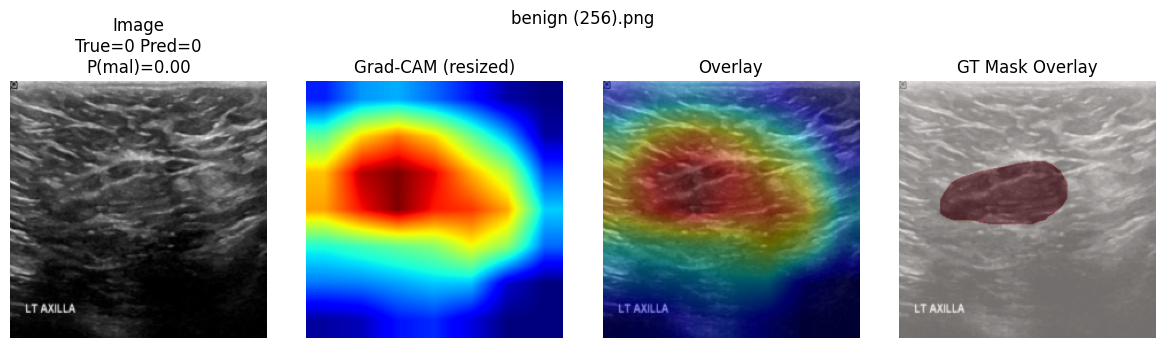

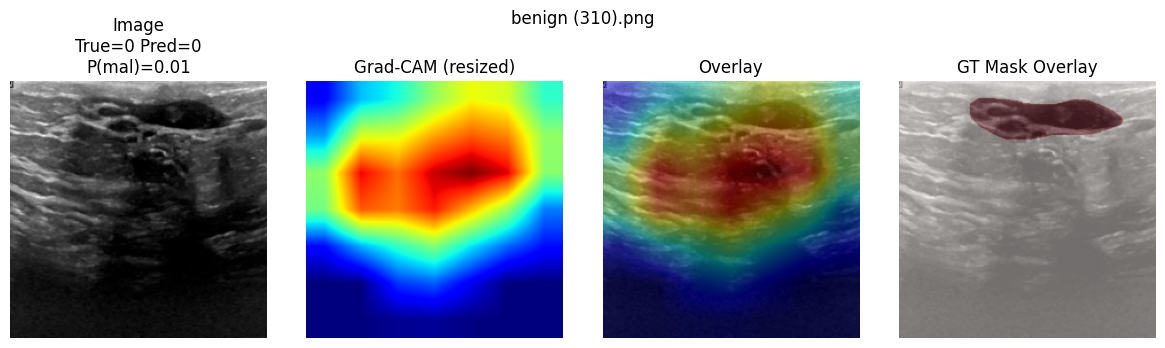

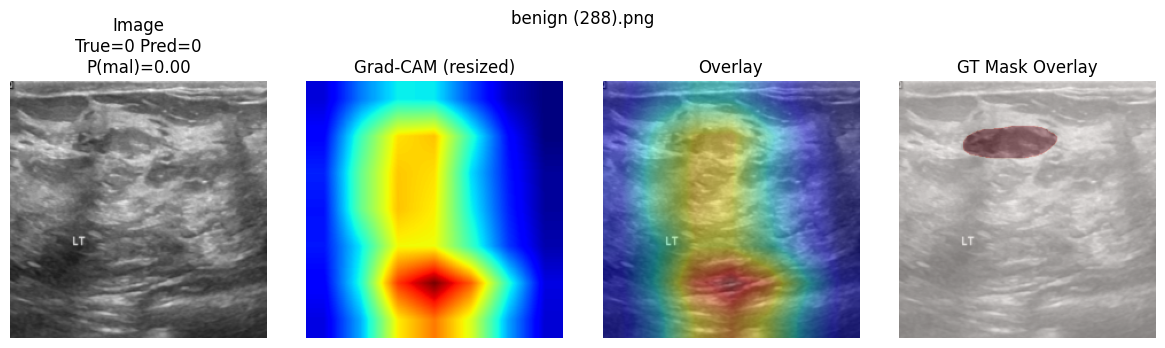

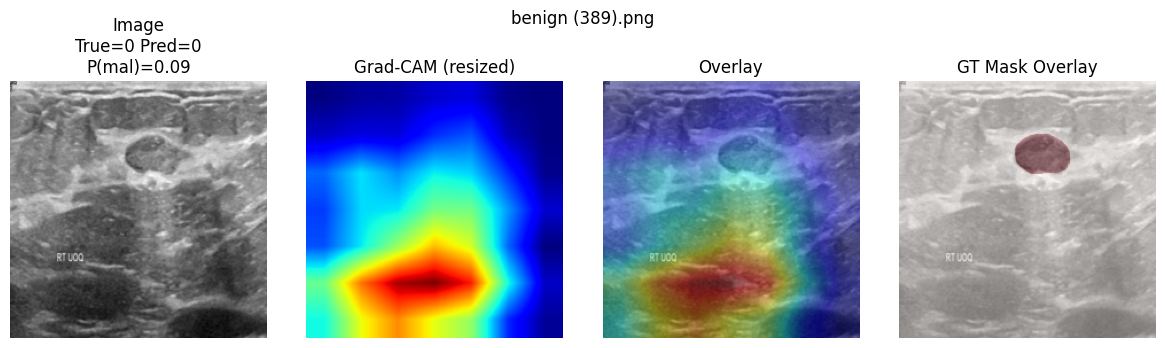

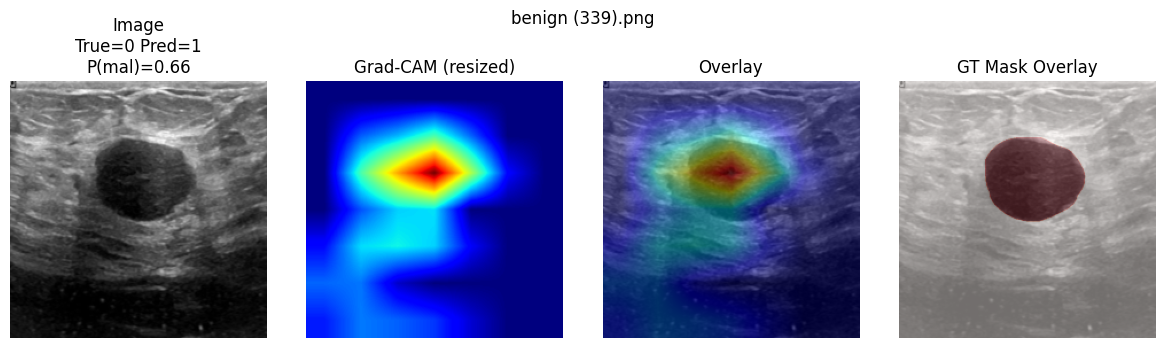

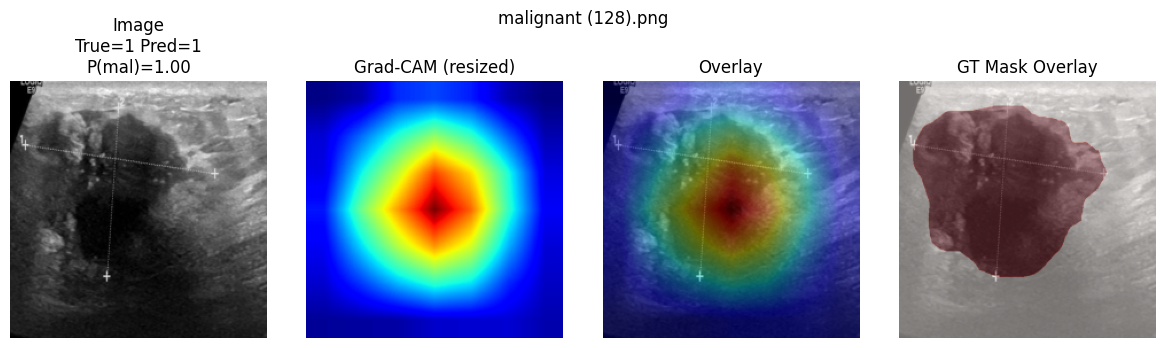

In [40]:
def show_examples(n=6, seed=7):
    import random, os
    random.seed(seed)
    images, labels, img_paths, mask_paths = next(iter(test_loader))

    idxs = list(range(images.size(0)))
    random.shuffle(idxs)
    idxs = idxs[:min(n, len(idxs))]

    for idx in idxs:
        x = images[idx].unsqueeze(0).to(device)
        true_label = int(labels[idx].item())
        img_path = img_paths[idx]
        mask_path = mask_paths[idx]

        with torch.no_grad():
            logits = model(x)
            prob_pos = torch.softmax(logits, dim=1)[0,1].item()
            pred = int(logits.argmax(dim=1).item())

        cam = gradcam.generate(x)
        img = denorm_img(images[idx])

        overlay, cam_resized = overlay_heatmap(img, cam, alpha=0.4)  # ✅ IMPORTANT
        mask = load_mask(mask_path, size=(IMG_SIZE, IMG_SIZE))

        plt.figure(figsize=(12,3.5))
        plt.subplot(1,4,1); plt.imshow(img); plt.axis("off")
        plt.title(f"Image\nTrue={true_label} Pred={pred}\nP(mal)={prob_pos:.2f}")

        plt.subplot(1,4,2); plt.imshow(cam_resized, cmap="jet"); plt.axis("off")
        plt.title("Grad-CAM (resized)")

        plt.subplot(1,4,3); plt.imshow(overlay); plt.axis("off")
        plt.title("Overlay")

        plt.subplot(1,4,4)
        if mask is None:
            plt.text(0.1, 0.5, "No mask found", fontsize=12); plt.axis("off")
        else:
            plt.imshow(img, alpha=0.85)
            plt.imshow(mask, cmap="Reds", alpha=0.35)
            plt.axis("off")
            plt.title("GT Mask Overlay")

        plt.suptitle(os.path.basename(img_path))
        plt.tight_layout()
        plt.show()

show_examples(n=6)


## 8) Save Grad-CAM Figures (for thesis/advisor updates)

Exports figures into `/content/results/gradcam/`.


In [38]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

os.makedirs("/content/results/gradcam", exist_ok=True)

def save_gradcam_examples(num_to_save=20):
    saved = 0
    model.eval()

    for images, labels, img_paths, mask_paths in test_loader:
        for i in range(images.size(0)):
            if saved >= num_to_save:
                print(f"Saved {saved} examples to /content/results/gradcam")
                return

            x = images[i].unsqueeze(0).to(device)
            true_label = int(labels[i].item())
            img_path = img_paths[i]
            mask_path = mask_paths[i]

            # Prediction (no grad)
            with torch.no_grad():
                logits = model(x)
                prob_pos = torch.softmax(logits, dim=1)[0, 1].item()
                pred = int(logits.argmax(dim=1).item())

            # Grad-CAM (needs grad internally)
            cam = gradcam.generate(x)  # usually (7,7)
            img = denorm_img(images[i])  # (224,224,3) float [0,1]

            # ✅ IMPORTANT: overlay_heatmap returns TWO things
            overlay, cam_resized = overlay_heatmap(img, cam, alpha=0.4)

            mask = load_mask(mask_path, size=(IMG_SIZE, IMG_SIZE))

            # Safety: ensure numpy arrays for imshow
            img = np.asarray(img, dtype=np.float32)
            overlay = np.asarray(overlay, dtype=np.float32)
            cam_resized = np.asarray(cam_resized, dtype=np.float32)
            if mask is not None:
                mask = np.asarray(mask, dtype=np.float32)

            fig = plt.figure(figsize=(12, 3.5))

            ax1 = plt.subplot(1,4,1)
            ax1.imshow(img); ax1.axis("off")
            ax1.set_title(f"True={true_label} Pred={pred}\nP(mal)={prob_pos:.2f}")

            ax2 = plt.subplot(1,4,2)
            ax2.imshow(cam_resized, cmap="jet"); ax2.axis("off")   # ✅ use resized
            ax2.set_title("Grad-CAM")

            ax3 = plt.subplot(1,4,3)
            ax3.imshow(overlay); ax3.axis("off")
            ax3.set_title("Overlay")

            ax4 = plt.subplot(1,4,4)
            if mask is None:
                ax4.text(0.1, 0.5, "No mask", fontsize=12); ax4.axis("off")
            else:
                ax4.imshow(img, alpha=0.85)
                ax4.imshow(mask, cmap="Reds", alpha=0.35)
                ax4.axis("off")
                ax4.set_title("GT Mask")

            fig.suptitle(os.path.basename(img_path))
            fig.tight_layout()

            out_name = f"ex_{saved:03d}_true{true_label}_pred{pred}.png"
            fig.savefig(f"/content/results/gradcam/{out_name}", dpi=150, bbox_inches="tight")
            plt.close(fig)

            saved += 1

save_gradcam_examples(num_to_save=20)
!ls -la /content/results/gradcam | head -n 30


Saved 20 examples to /content/results/gradcam
total 11924
drwxr-xr-x 2 root root   4096 Feb 16 02:08 .
drwxr-xr-x 3 root root   4096 Feb 16 00:03 ..
-rw-r--r-- 1 root root 638283 Feb 16 02:07 ex_000_true0_pred0.png
-rw-r--r-- 1 root root 550169 Feb 16 02:07 ex_001_true1_pred1.png
-rw-r--r-- 1 root root 600741 Feb 16 02:07 ex_002_true0_pred0.png
-rw-r--r-- 1 root root 622908 Feb 16 02:07 ex_003_true0_pred0.png
-rw-r--r-- 1 root root 609224 Feb 16 02:07 ex_004_true0_pred0.png
-rw-r--r-- 1 root root 656285 Feb 16 02:07 ex_005_true0_pred0.png
-rw-r--r-- 1 root root 602462 Feb 16 02:07 ex_006_true0_pred0.png
-rw-r--r-- 1 root root 612614 Feb 16 02:07 ex_007_true0_pred0.png
-rw-r--r-- 1 root root 578101 Feb 16 02:07 ex_008_true0_pred0.png
-rw-r--r-- 1 root root 643645 Feb 16 02:07 ex_009_true0_pred0.png
-rw-r--r-- 1 root root 671435 Feb 16 02:07 ex_010_true0_pred0.png
-rw-r--r-- 1 root root 613562 Feb 16 02:07 ex_011_true1_pred1.png
-rw-r--r-- 1 root root 671215 Feb 16 02:07 ex_012_true0_pre